In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download vivektalwar13071999/final-oralv1

 99% 1.04G/1.05G [00:06<00:00, 205MB/s]
100% 1.05G/1.05G [00:06<00:00, 167MB/s]


In [7]:
!unzip /content/final-oralv1.zip

Archive:  /content/final-oralv1.zip
  inflating: final_oral/test/non-suspicious/1_0GMsu0AKOlhyYfpSr5DGMJRZLlzwVuFj.jpg  
  inflating: final_oral/test/non-suspicious/1_0Jtkq6tpjENPYGcmwOEeF1kv5yTelaUi.jpg  
  inflating: final_oral/test/non-suspicious/1_0hFhiB4U85CWQYBHYDmkNq14whOOKX6G.jpg  
  inflating: final_oral/test/non-suspicious/1_0jVhFFCsdUtUEC1Ao6KW555kyfSnRxjA.jpg  
  inflating: final_oral/test/non-suspicious/1_11CxWXdQLKtNda92rfxBGQoYFEwrUlVT.jpg  
  inflating: final_oral/test/non-suspicious/1_16ipgfD9jYe9JFy5RO8yeWnYmGfBbxoF.jpg  
  inflating: final_oral/test/non-suspicious/1_19e1bzOUVdJqdTneNkJXcJw32eDNnU9d.jpg  
  inflating: final_oral/test/non-suspicious/1_1Db0wCHeLVAFqDructEaSj6vX6PKMzN3.jpg  
  inflating: final_oral/test/non-suspicious/1_22XKwuf5tBsGQv6f6WdvoVSMYJhmANnk.jpg  
  inflating: final_oral/test/non-suspicious/1_27bd9bTcsiDex4b8W595lpl0aNUpHpvC.jpg  
  inflating: final_oral/test/non-suspicious/1_2ak4W1TUxHZAN823iH19zMGexfPlmRsq.jpg  
  inflating: final_oral/test/

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# We use a butterfly dataset of 50 species to demonstrate the classification method

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [104]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Embedding, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import DenseNet201,InceptionResNetV2,ResNet50,VGG19,MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import plotly.express as px
import torch
import torchvision
from torchvision import transforms as T # for simplifying the transforms
plt.rcParams['font.size'] =  12

In [12]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 5.1 MB/s 
     |████████████████████████████████| 182 kB 83.8 MB/s 


In [13]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline


In [15]:
import sys
from tqdm import tqdm
import time
import copy


In [16]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [17]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [18]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)


In [19]:

dataset_path = "/content/final_oral"

train_dir = "/content/final_oral/train"

val_dir = "/content/final_oral/val"

test_dir = "/content/final_oral/test"

In [20]:
import os
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [21]:

classes = get_classes("/content/final_oral/train/")
print(classes, len(classes))

['non-suspicious', 'suspicious'] 2


In [22]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}


In [23]:
print(len(train_loader), len(val_loader), len(test_loader))

11 13 14


In [24]:
print(train_data_len, valid_data_len, test_data_len)


1344 412 422


In [25]:
# Set up variables for pre-processing
batch_size = 64
epochs = 5
IMG_HEIGHT = 224
IMG_WIDTH = 224

Class names:  ['non-suspicious' 'suspicious']
Found 1344 images belonging to 2 classes.


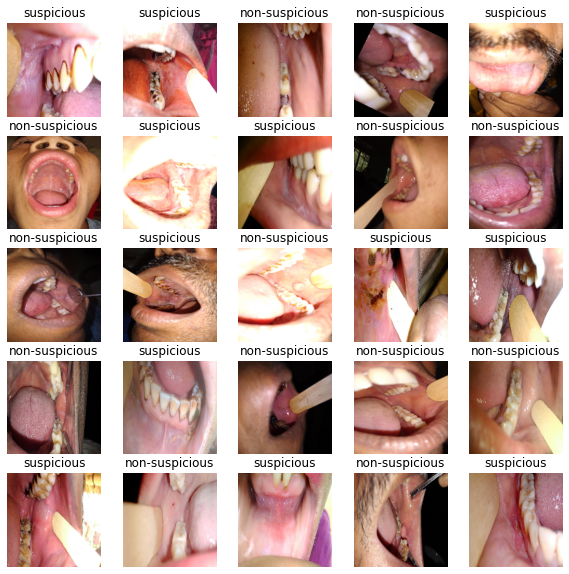

In [26]:

import os
import pathlib
from time import time
# Visualize some images
train_root = pathlib.Path(train_dir)
class_names = sorted([j.name.split('/')[-1] for j in train_root.iterdir()])
class_names = np.array(class_names)
print('Class names: ', class_names)

img_gen = ImageDataGenerator(rescale = 1./255)
sample_train_data_gen = img_gen.flow_from_directory(batch_size = batch_size,
                                                    directory = train_dir,
                                                    shuffle = True,
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(class_names))
                                                 
sample_images, sample_labels = next(sample_train_data_gen)

def show_batch(img_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(class_names[sample_labels[i] == 1][0])
        plt.axis('off')
        
show_batch(sample_images, sample_labels)



In [27]:
train_image_generator = ImageDataGenerator(rescale = 1./255,
                                           rotation_range = 45,
                                           width_shift_range = 0.20,
                                           height_shift_range = 0.20,
                                           horizontal_flip = True,
                                           zoom_range = 0.5)

val_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'categorical')

val_data_gen = val_image_generator.flow_from_directory(batch_size = batch_size,
                                                       directory = val_dir,
                                                       target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode = 'categorical')

test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 1344 images belonging to 2 classes.
Found 412 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [28]:


# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [105]:

img_size = 512

base_model = MobileNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(img_size,img_size,3))


9406464/9406464 [==============================] - 0s 0us/step


In [106]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [107]:

freeze_index = None
for i,layer in enumerate(base_model.layers):
    if 'conv4' in layer._name:
        freeze_index = i
        break
        
for layer in base_model.layers[:freeze_index]:
    layer.trainable = False

In [108]:
freeze_index = None
for i,layer in enumerate(base_model.layers):
    if 'conv4' in layer._name:
        freeze_index = i
        break
        
for layer in base_model.layers[:freeze_index]:
    layer.trainable = False

In [109]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [110]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [111]:

history = model.fit(train_data_gen,
                    epochs=15,
                    validation_data=val_data_gen,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])



Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.5692
Epoch 1: val_loss improved from inf to 0.60252, saving model to model.h5
21/21 [==============================] - 189s 9s/step - loss: 0.7074 - accuracy: 0.5692 - val_loss: 0.6025 - val_accuracy: 0.6845 - lr: 1.0000e-04
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.6182 - accuracy: 0.6689
Epoch 2: val_loss did not improve from 0.60252
21/21 [==============================] - 178s 9s/step - loss: 0.6182 - accuracy: 0.6689 - val_loss: 0.6315 - val_accuracy: 0.6529 - lr: 1.0000e-04
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.7083
Epoch 3: val_loss improved from 0.60252 to 0.54496, saving model to model.h5
21/21 [==============================] - 179s 9s/step - loss: 0.5574 - accuracy: 0.7083 - val_loss: 0.5450 - val_accuracy: 0.7354 - lr: 1.0000e-04
Epoch 4/15
21/21 [==============================] - ETA: 0s - loss: 0.5470 - acc

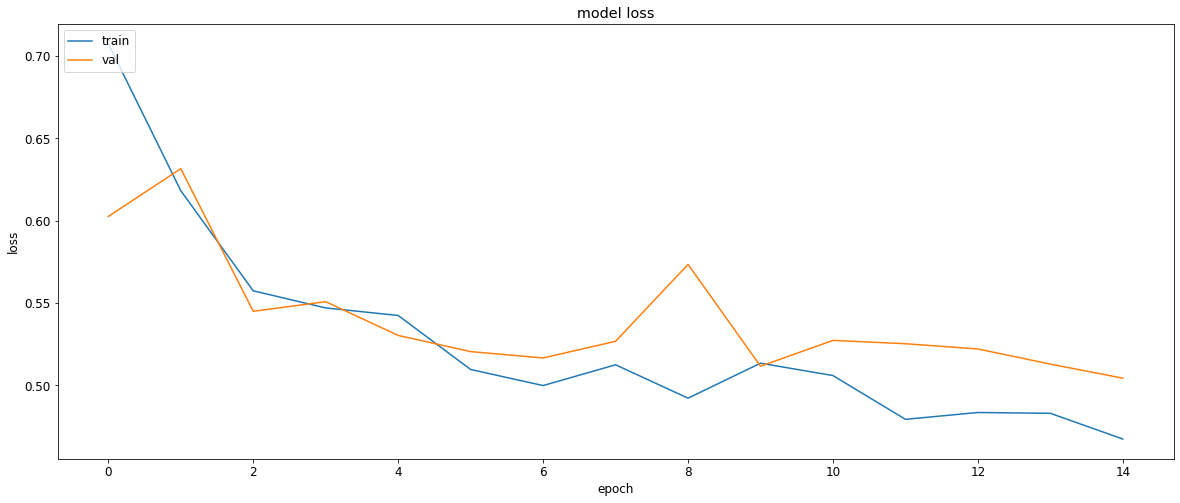

In [112]:

plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

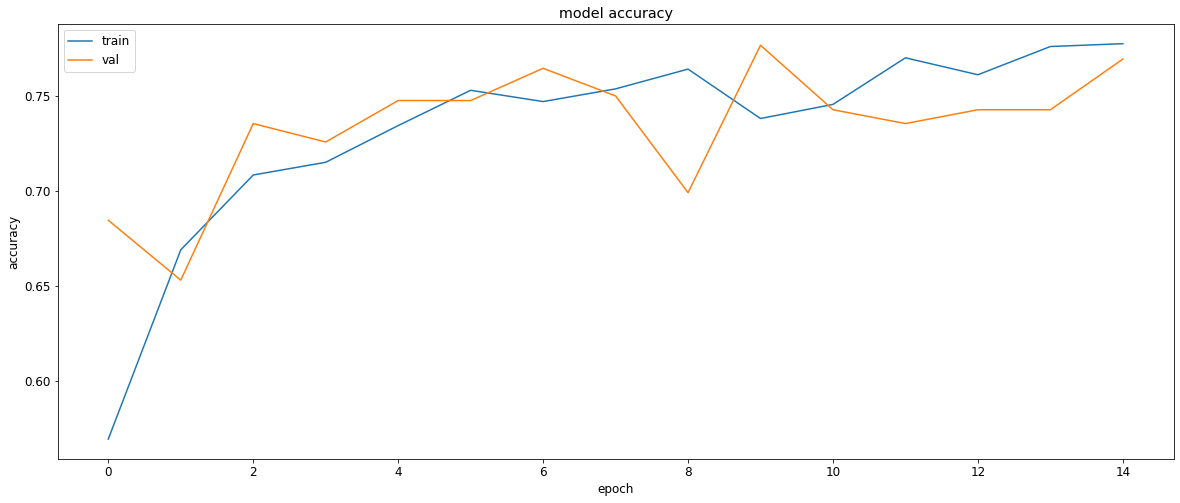

In [113]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [114]:


y_test = test_data_gen.classes
y_pred = model.predict(test_data_gen)
y_pred = np.argmax(y_pred,axis=1)


7/7 [==============================] - 44s 6s/step


In [115]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred,target_names = classes))

                precision    recall  f1-score   support

non-suspicious       0.75      0.73      0.74       206
    suspicious       0.75      0.76      0.76       216

      accuracy                           0.75       422
     macro avg       0.75      0.75      0.75       422
  weighted avg       0.75      0.75      0.75       422



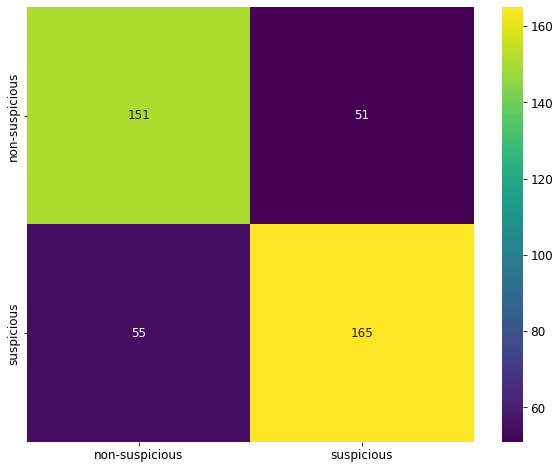

In [116]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt='.3g',xticklabels=classes,yticklabels=classes,cmap='viridis')
plt.show()